In [14]:
import os
import zipfile
import random
import json
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torchmetrics

In [15]:
class dataset(Dataset):
    def __init__(self, data_path, mode='train'):
        """
        数据读取器
        :param data_path: 数据集所在路径
        :param mode: train or eval
        """
        super().__init__()
        self.data_path = data_path
        self.img_paths = []
        self.labels = []

        if mode == 'train':
            with open(os.path.join(self.data_path, "train.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                #if int(img_path) > 500:
                #    continue
                self.img_paths.append("images/"+img_path + ".jpg")
                self.labels.append(int(label))

        else:
            with open(os.path.join(self.data_path, "test.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path = img_info.strip()
                #if int(img_path) > 500:
                #    continue
                self.img_paths.append("images/"+img_path + ".jpg")
                

    def __getitem__(self, index):
        """
        获取一组数据
        :param index: 文件索引号
        :return:
        """
        # 第一步打开图像文件并获取label值
        img_path = self.img_paths[index]
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB') 
        img = img.resize((224, 224), Image.BILINEAR)
        img = np.array(img).astype('float32')
        img = img.transpose((2, 0, 1)) / 255
        label = self.labels[index]
        label = np.array([label], dtype="int64")
        return img, label

    def print_sample(self, index: int = 0):
        print("文件名", self.img_paths[index], end="\t")
        if self.labels !=[]:
            print("标签值", self.labels[index], end="")
        print()

    def __len__(self):
        return len(self.img_paths)

In [16]:
#训练数据加载
train_dataset = dataset('',mode='train')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
#测试数据加载
eval_dataset = dataset('',mode='eval')
eval_loader = DataLoader(eval_dataset, batch_size = 8, shuffle=False)

In [17]:
train_dataset.print_sample(100)
print(train_dataset.__len__())
eval_dataset.print_sample(0)
print(eval_dataset.__len__())

文件名 images/6875.jpg	标签值 5
7999
文件名 images/4940.jpg	
1145


In [18]:
class_dim = 102

In [19]:
import torch.nn as nn
import math
class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.features = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.ReLU(True),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(True),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.ReLU(True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.ReLU(True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        ).to(self.device)
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7,4096),
            nn.ReLU(True),
            nn.Linear(4096,4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096,class_dim),
        ).to(self.device)
    def forward(self,x):
        x = x.to(self.device)
        x = self.features(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

In [20]:
def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

In [21]:
num_epochs = 20
skip_steps = 10
save_steps = 30
lr = 0.0001
checkpoints = "./checkpoints"

In [ ]:
model = VGG()
model.train()
cross_entropy = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr) 

steps = 0
Epoch, total_loss, total_acc = [], [], []

for epo in range(num_epochs):
    loss_rec = 0
    acc_rec = 0
    for x_data, y_data in train_loader:
        steps += 1
        predicts= model(x_data)
        y_data = y_data.to(model.device)
        loss = cross_entropy(predicts, y_data.squeeze(dim=1)).to(model.device)
        loss_rec += loss.cpu().detach().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # optimizer.clear_grad()
        acc = torchmetrics.functional.accuracy(predicts, y_data.squeeze(dim=1))
        acc_rec += acc.cpu().detach().item()
        
    loss_rec = loss_rec/len(train_loader)
    acc_rec = acc_rec/len(train_loader)
    Epoch.append(epo)
    total_loss.append(loss_rec)
    total_acc.append(acc_rec)
    #打印中间过程
    print('epo: {}, loss is: {:.6f}, acc is: {:.6f}'.format(epo, loss_rec, acc_rec))

/home/ma-user/anaconda3/envs/PyTorch-1.8/lib/python3.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.


epo: 0, loss is: 4.230544, acc is: 0.083000
epo: 1, loss is: 4.202988, acc is: 0.085883
epo: 2, loss is: 4.196461, acc is: 0.084267
epo: 3, loss is: 4.192036, acc is: 0.087767
epo: 4, loss is: 4.194060, acc is: 0.089267
epo: 5, loss is: 4.192475, acc is: 0.090525
epo: 6, loss is: 4.188179, acc is: 0.087633
epo: 7, loss is: 4.189020, acc is: 0.086500
epo: 8, loss is: 4.188471, acc is: 0.085758
epo: 9, loss is: 4.184476, acc is: 0.088633
epo: 10, loss is: 4.186679, acc is: 0.087375


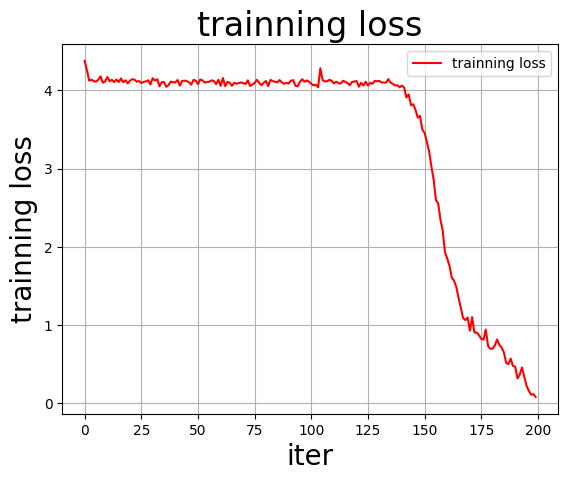

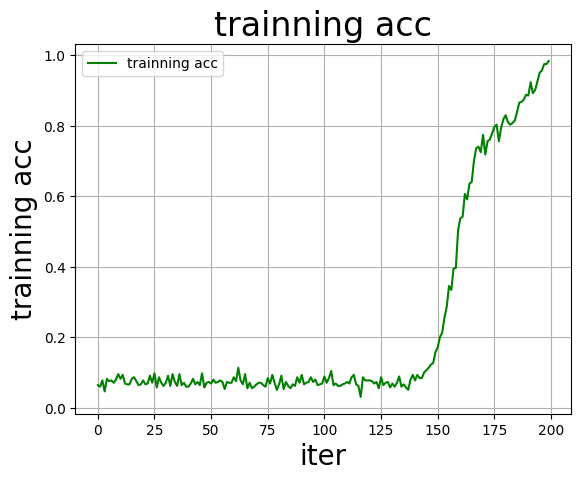

In [37]:
import numpy as np

torch.save(model.state_dict(),"save_model.pdparams")
loss_list = np.array(total_loss)
acc_list = np.array(total_acc)
epoch_list = np.array(Epoch)
np.save('epoch_list.npy', epoch_list)
np.save('loss.npy',loss_list)
np.save( 'acc.npy',acc_list)
draw_process("trainning loss","red",Epoch,total_loss,"trainning loss")
draw_process("trainning acc","green",Epoch,total_acc,"trainning acc")

#loss = np.load('loss.npy')
#draw_process("trainning loss","red",Epoch,loss,"trainning loss")
#acc = np.load('acc.npy')
#draw_process("trainning loss","red",Epoch,acc,"trainning loss")

In [38]:
def load_image(img_path):
    '''
    预测图片预处理
    '''
    img = Image.open(img_path) 
    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    img = img.resize((224, 224), Image.BILINEAR)
    img = np.array(img).astype('float32') 
    img = img.transpose((2, 0, 1)) / 255 # HWC to CHW 及归一化
    return img

img_paths = []
with open("test.txt", "r", encoding="utf-8") as f:
    info = f.readlines()
for img_info in info:
    img_path = img_info.strip()
    img_paths.append("images/"+img_path)


In [ ]:

model__state_dict = torch.load('save_model.pdparams')
model_predict = VGG()
model_predict.set_state_dict(model__state_dict) 
model_predict.eval()

f_write = open("result.txt", "w")

for img_path in img_paths:
    infer_img = load_image(img_path)
    img_name = img_path.split('/')[-1]
    infer_img = infer_img[np.newaxis,:, : ,:]  #reshape(-1,3,224,224)
    infer_img = torch.to_tensor(infer_img).to(model_predict.device)
    result = model_predict(infer_img)
    lab = np.argmax(result.cpu().detach().numpy())
    if img_path == img_paths[-1]:
        f_write.write(img_name+"\t"+str(lab))
    else:
        f_write.write(img_name+"\t"+str(lab)+"\n")

f_write.close()

NameError: name 'torch' is not defined